In [64]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import scipy.stats 
import matplotlib.pyplot as plt
import numpy as np

Differencing

<Figure size 1000x600 with 0 Axes>

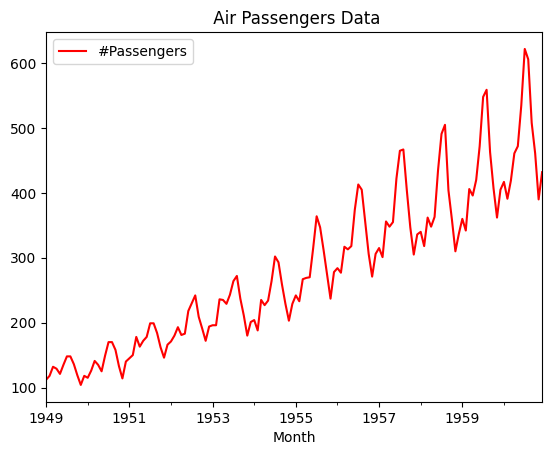

In [15]:
df = pd.read_csv(r'Youtube\Egor Books\Youtube-main\Youtube-main\Time-Series-Crash-Course\AirPassengers.csv', index_col = 'Month', parse_dates = True)
plt.figure(figsize=(10,6))
df.plot(title=' Air Passengers Data', color='red')
plt.legend()

In [27]:
#Use .diff() to calculate first order difference
df['#Passengers_Differenced'] = df['#Passengers'].diff()
#Take Log of the data to stabilize the variance
df['#Passengers_Log'] = np.log(df['#Passengers'])
df['#Passengers_Differenced_Log'] = df['#Passengers_Log'].diff()


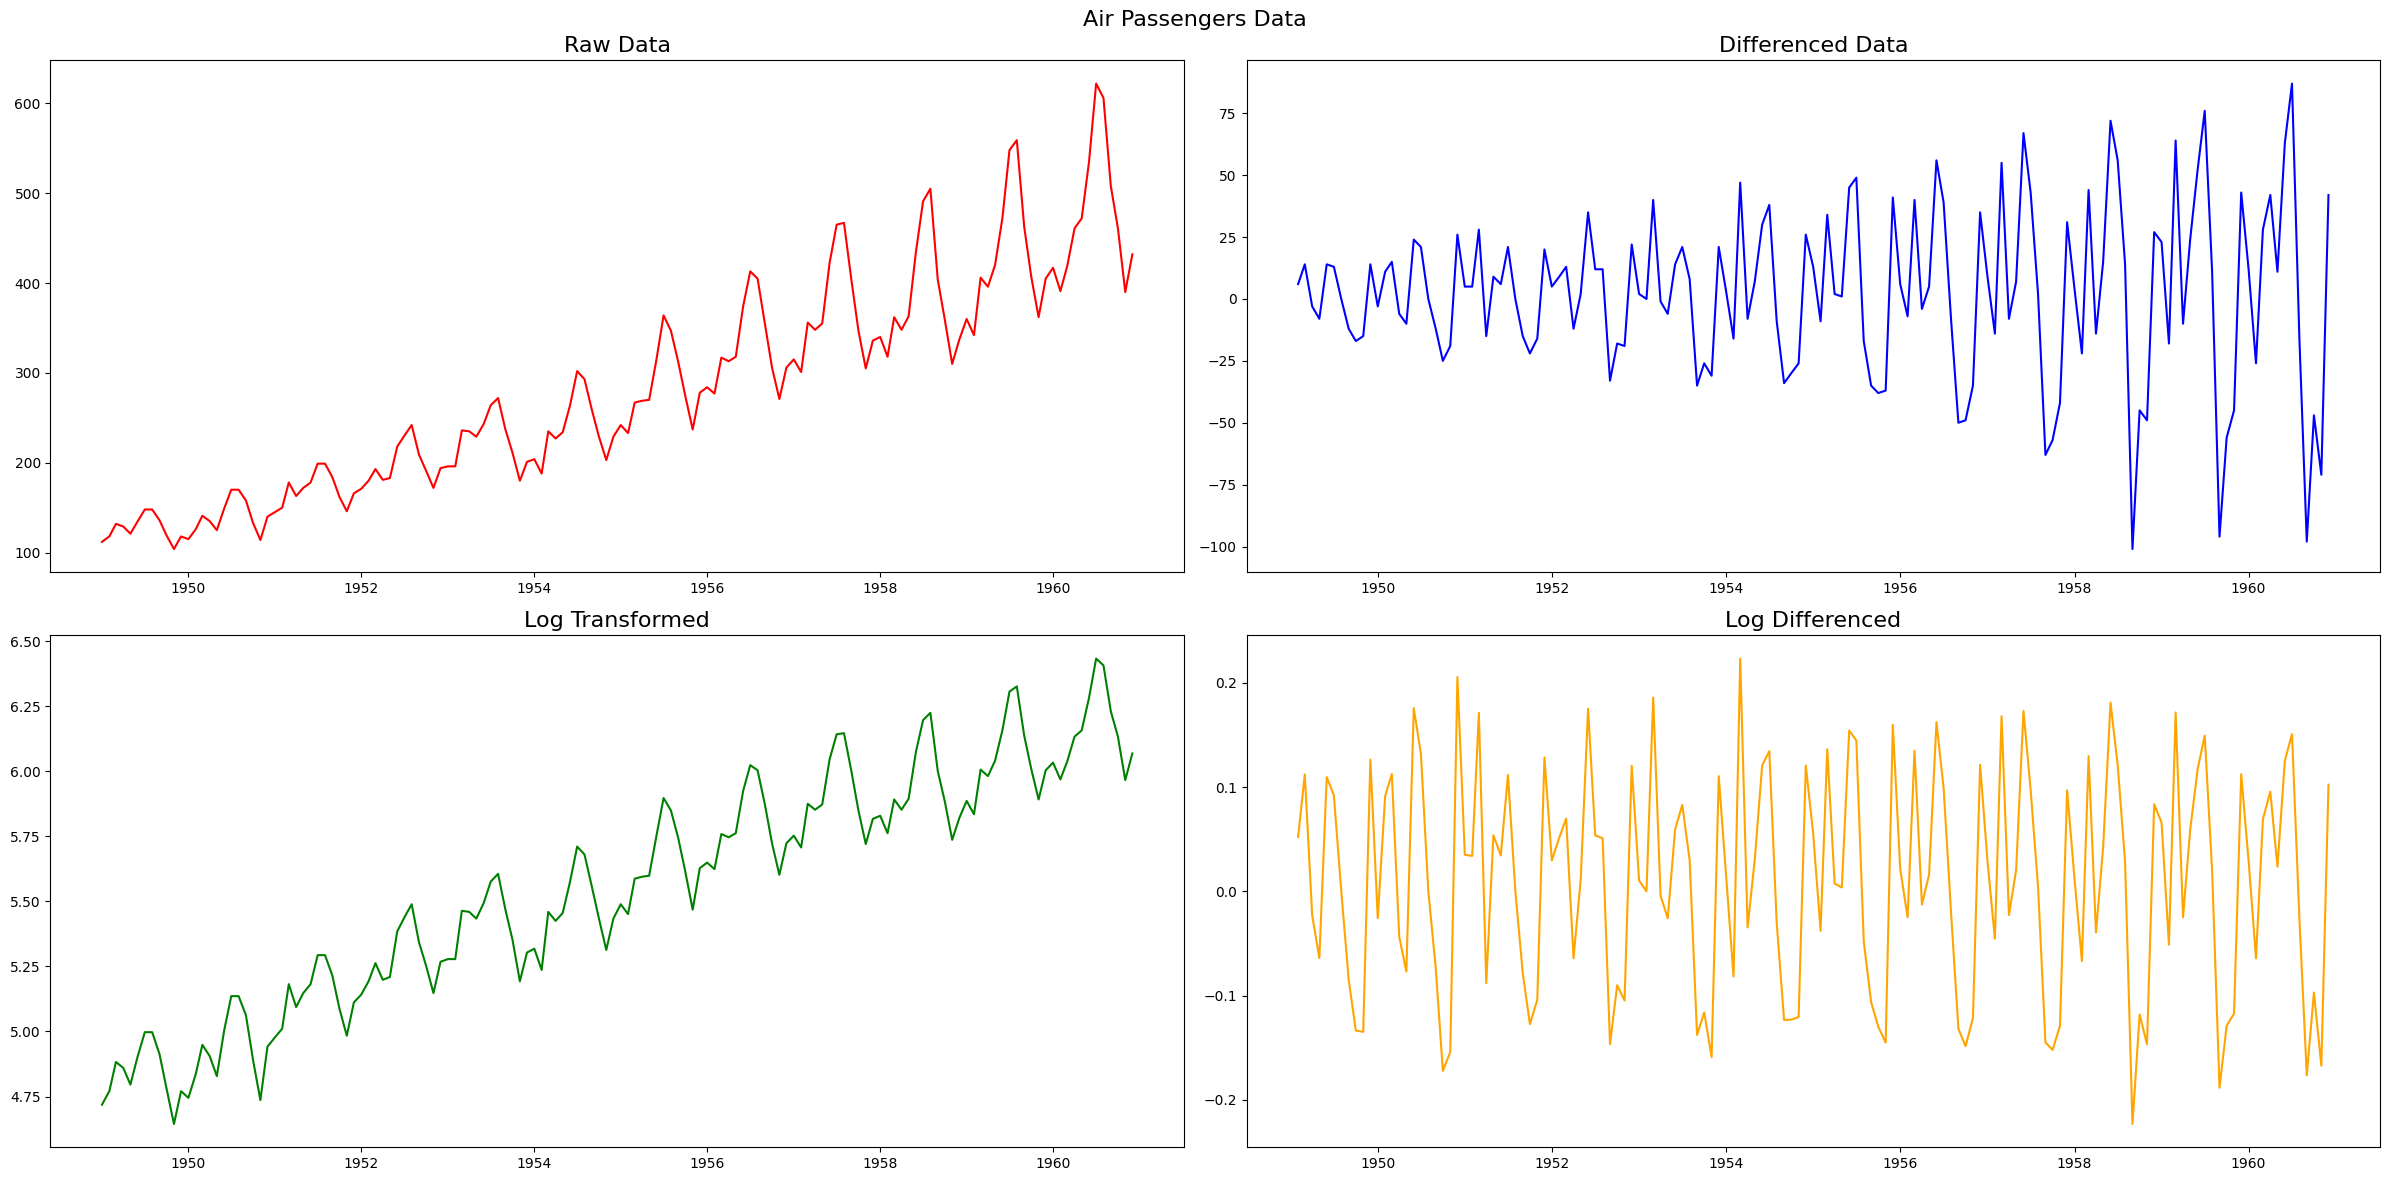

In [139]:
#Plot the data
fig, axs = plt.subplots(2,2, figsize=(24,12))
fig.suptitle('Air Passengers Data', fontsize=16)
ax1, ax2, ax3, ax4 = axs.ravel()
ax1.plot(df['#Passengers'], label='Air Passengers', color='red')
ax1.set_title('Raw Data', fontsize=16)
ax2.plot(df['#Passengers_Differenced'], label='Air Passengers Differenced', color='blue')
ax2.set_title('Differenced Data',fontsize=16)
ax3.plot(df['#Passengers_Log'], label='Air Passengers Log', color='green')
ax3.set_title('Log Transformed',fontsize=16)
ax4.plot(df['#Passengers_Differenced_Log'], label='Air Passengers Differenced Log', color='orange')
ax4.set_title('Log Differenced', fontsize=16)

plt.tight_layout()

## Tests for Stationarity

### ADF Hypothesis Test

In [60]:
'''
Use adfuller(x, maxlag=None, regression='c', autolag
='AIC', store=False, regresults=False)

Returns the following:
    - adf (float) – Test statistic
    - pvalue (float) – p-value    
'''
def ADF_test(time_series):
    test_results = adfuller(time_series.dropna())
    test_statistic = test_results[0]
    p_value = test_results[1]

    #Critical Values
    Critical_Values = {}
    for threshold, adf_stat in test_results[4].items():
        Critical_Values[threshold] = adf_stat

    return test_statistic, p_value, Critical_Values['1%'], Critical_Values['5%'], Critical_Values['10%'] 

Results = df.apply(lambda col : ADF_test(col)).round(2)
Results.index = ['T-stat', 'p-value', '1%', '5%', '10%']
Results

,#Passengers,#Passengers_Differenced,#Passengers_Log,#Passengers_Differenced_Log
T-stat,0.82,-2.83,-1.72,-2.72
p-value,0.99,0.05,0.42,0.07
1%,-3.48,-3.48,-3.48,-3.48
5%,-2.88,-2.88,-2.88,-2.88
10%,-2.58,-2.58,-2.58,-2.58


## Box Cox Transformation

Box-Cox transforms non normal data (do it on raw data) to normal distribution like data. This is because models like ARIMA use MLE which requires assumptions about distributions

Lambda parameter controls the order of the transformation. If lambda = 0, this is just ln(y) transform. For other values of lambda, it is a n^th order transformation divided by that n 

<Axes: title={'center': 'BoxCox Transformed Differenced Data, with lambda = 0.148'}, xlabel='Month'>

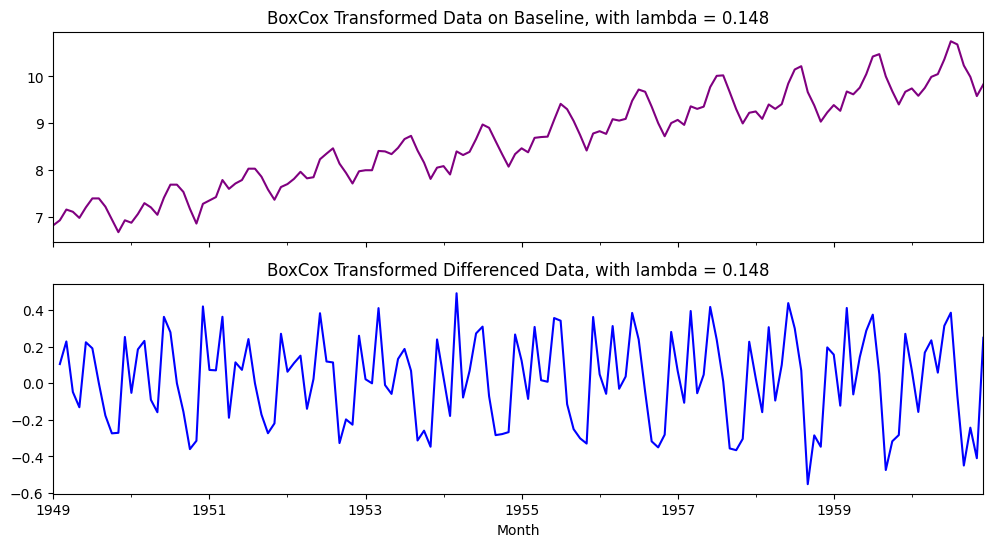

In [84]:
#Use scipy's boxcox to transform the data. It picks the optimal lambda value
fig, axs = plt.subplots(2,1, sharex= True, figsize=(12,6))
df['#Passengers_BoxCox_Transformed'], lam = scipy.stats.boxcox(df['#Passengers'])
#Plot the data
df['#Passengers_BoxCox_Transformed'].plot(ax=axs[0], title=f'BoxCox Transformed Data on Baseline, with lambda = {lam.round(3)}', color='purple')

#Plot differenced Box Cox 
df['#Passengers_BoxCox_Transformed_Differenced'] = df['#Passengers_BoxCox_Transformed'].diff()
df['#Passengers_BoxCox_Transformed_Differenced'].plot(ax=axs[1], title=f'BoxCox Transformed Differenced Data, with lambda = {lam.round(3)}', color='blue')

## Seasonality

We can see seasonality occurs at m = 12 interval. We difference with m = 12 to get rid of this.

C:\Users\Phillip\AppData\Local\Temp\ipykernel_12088\3061998492.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['#Passengers'].resample('M').mean().plot(title='Monthly Passenger Volume', ax=axs[0], ylabel = 'Passengers')


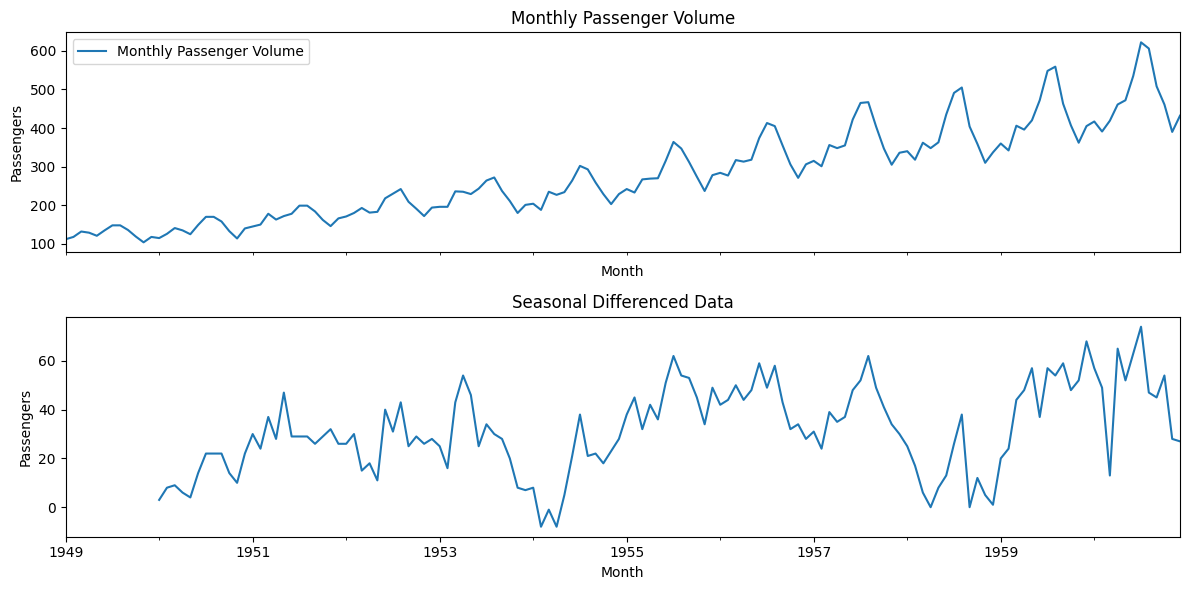

In [120]:
from matplotlib import dates as mdate
import datetime as dt
#We can observe the seasonality in the data
fig, axs = plt.subplots(2,1, sharex= False, figsize=(12,6))
df['#Passengers'].resample('M').mean().plot(title='Monthly Passenger Volume', ax=axs[0], ylabel = 'Passengers')
axs[0].legend(['Monthly Passenger Volume'])
#mdate.YearLocator() → Places major ticks at the start of each year.
#mdate.DateFormatter('%Y') → Formats the x-axis labels to display only the year (e.g., 2020, 2021).
axs[0].xaxis.set_major_locator(mdate.YearLocator())
axs[0].xaxis.set_major_formatter(mdate.DateFormatter('%Y'))
#Difference with m = 12 using .diff(periods = 12)
df['#Passengers_Differenced_Seasonal'] = df['#Passengers'].diff(periods=12)
df['#Passengers_Differenced_Seasonal'].plot(ax=axs[1], title='Seasonal Differenced Data', ylabel = 'Passengers')
plt.tight_layout()

In [117]:
#Apply ADF Test Again - It is stationary under 5% significance level
test_results = adfuller(df['#Passengers_Differenced_Seasonal'].dropna())
print(f'P Value: {test_results[1].round(4)*100}%')


P Value: 1.16%
